In [1]:
%load_ext memory_profiler

## Load Dependancies 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR

from sklearn import datasets
import scipy.stats as stats
import lightgbm as lgb
import xgboost as xgb

from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import numpy as np

import dask
from dask.distributed import worker_client
from dask.distributed import Client,LocalCluster

import joblib
import numpy as np
from dask.distributed import Client

import joblib
from sklearn.datasets import load_digits
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from xgboost import XGBRegressor

## test a simple model

In [ ]:
%%time
from sklearn.model_selection import KFold

input_file = Path("../data/formated_dataset.csv")

df = pd.read_csv(input_file).astype('float32')
y = df['target'].values
X = df.drop("target",axis=1).values

model = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
kf = KFold(n_splits=5,shuffle=True, random_state=3)
cv_scores = cross_val_score(model, X, y, cv=kf,scoring='r2', n_jobs=-1)
mean_score = np.mean(cv_scores)
print("cv_scores",cv_scores)
print("mean_score",mean_score)

In [ ]:
# cv_scores [0.87396393 0.88261499 0.88229653 0.87559723 0.8776003 ]
# mean_score 0.8784145946557445
# CPU times: user 2.31 s, sys: 220 ms, total: 2.53 s
# Wall time: 10.2 s

In [3]:

%%time
from sklearn.model_selection import KFold

input_file = Path("../data/max_abs_df.csv")



df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
y = df['target'].values
X = df.drop("target",axis=1).values

model = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
kf = KFold(n_splits=5,shuffle=True, random_state=3)
cv_scores = cross_val_score(model, X, y, cv=kf,scoring='r2', n_jobs=-1)
mean_score = np.mean(cv_scores)
print("cv_scores",cv_scores)
print("mean_score",mean_score)

cv_scores [nan nan nan nan nan]
mean_score nan
CPU times: user 3.28 s, sys: 292 ms, total: 3.57 s
Wall time: 5.23 s


In [3]:
%%time
from sklearn.model_selection import KFold

input_file = Path("../data/formated_dataset.csv")
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
y = df['target'].values
X = df.drop("target",axis=1).values

model = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
kf = KFold(n_splits=5,shuffle=True, random_state=3)
cv_scores = cross_val_score(model, X, y, cv=kf,scoring='r2', n_jobs=-1)
mean_score = np.mean(cv_scores)
print("cv_scores",cv_scores)
print("mean_score",mean_score)

cv_scores [0.87180407 0.88140205 0.87870391 0.87089168 0.87373772]
mean_score 0.8753078862287268
CPU times: user 2.16 s, sys: 284 ms, total: 2.44 s
Wall time: 5min


In [ ]:
## Plot Feature Importance

In [14]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from pathlib import Path
# load data
input_file = Path("../data/max_abs_df.csv")
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
y = df['target'].values
X = df.drop("target",axis=1)

dtrain = xgb.DMatrix(data=X.values, label=y, feature_names=X.columns.values)

# fit model no training data
model = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
model.fit(X, y)
# plot feature importance


In [18]:
fitted.best_score

AttributeError: 'XGBRegressor' object has no attribute 'best_score'

In [20]:
from sklearn.metrics import r2_score

train_out = model.predict(X)
score = r2_score(y,train_out)
score

0.9271526806860428

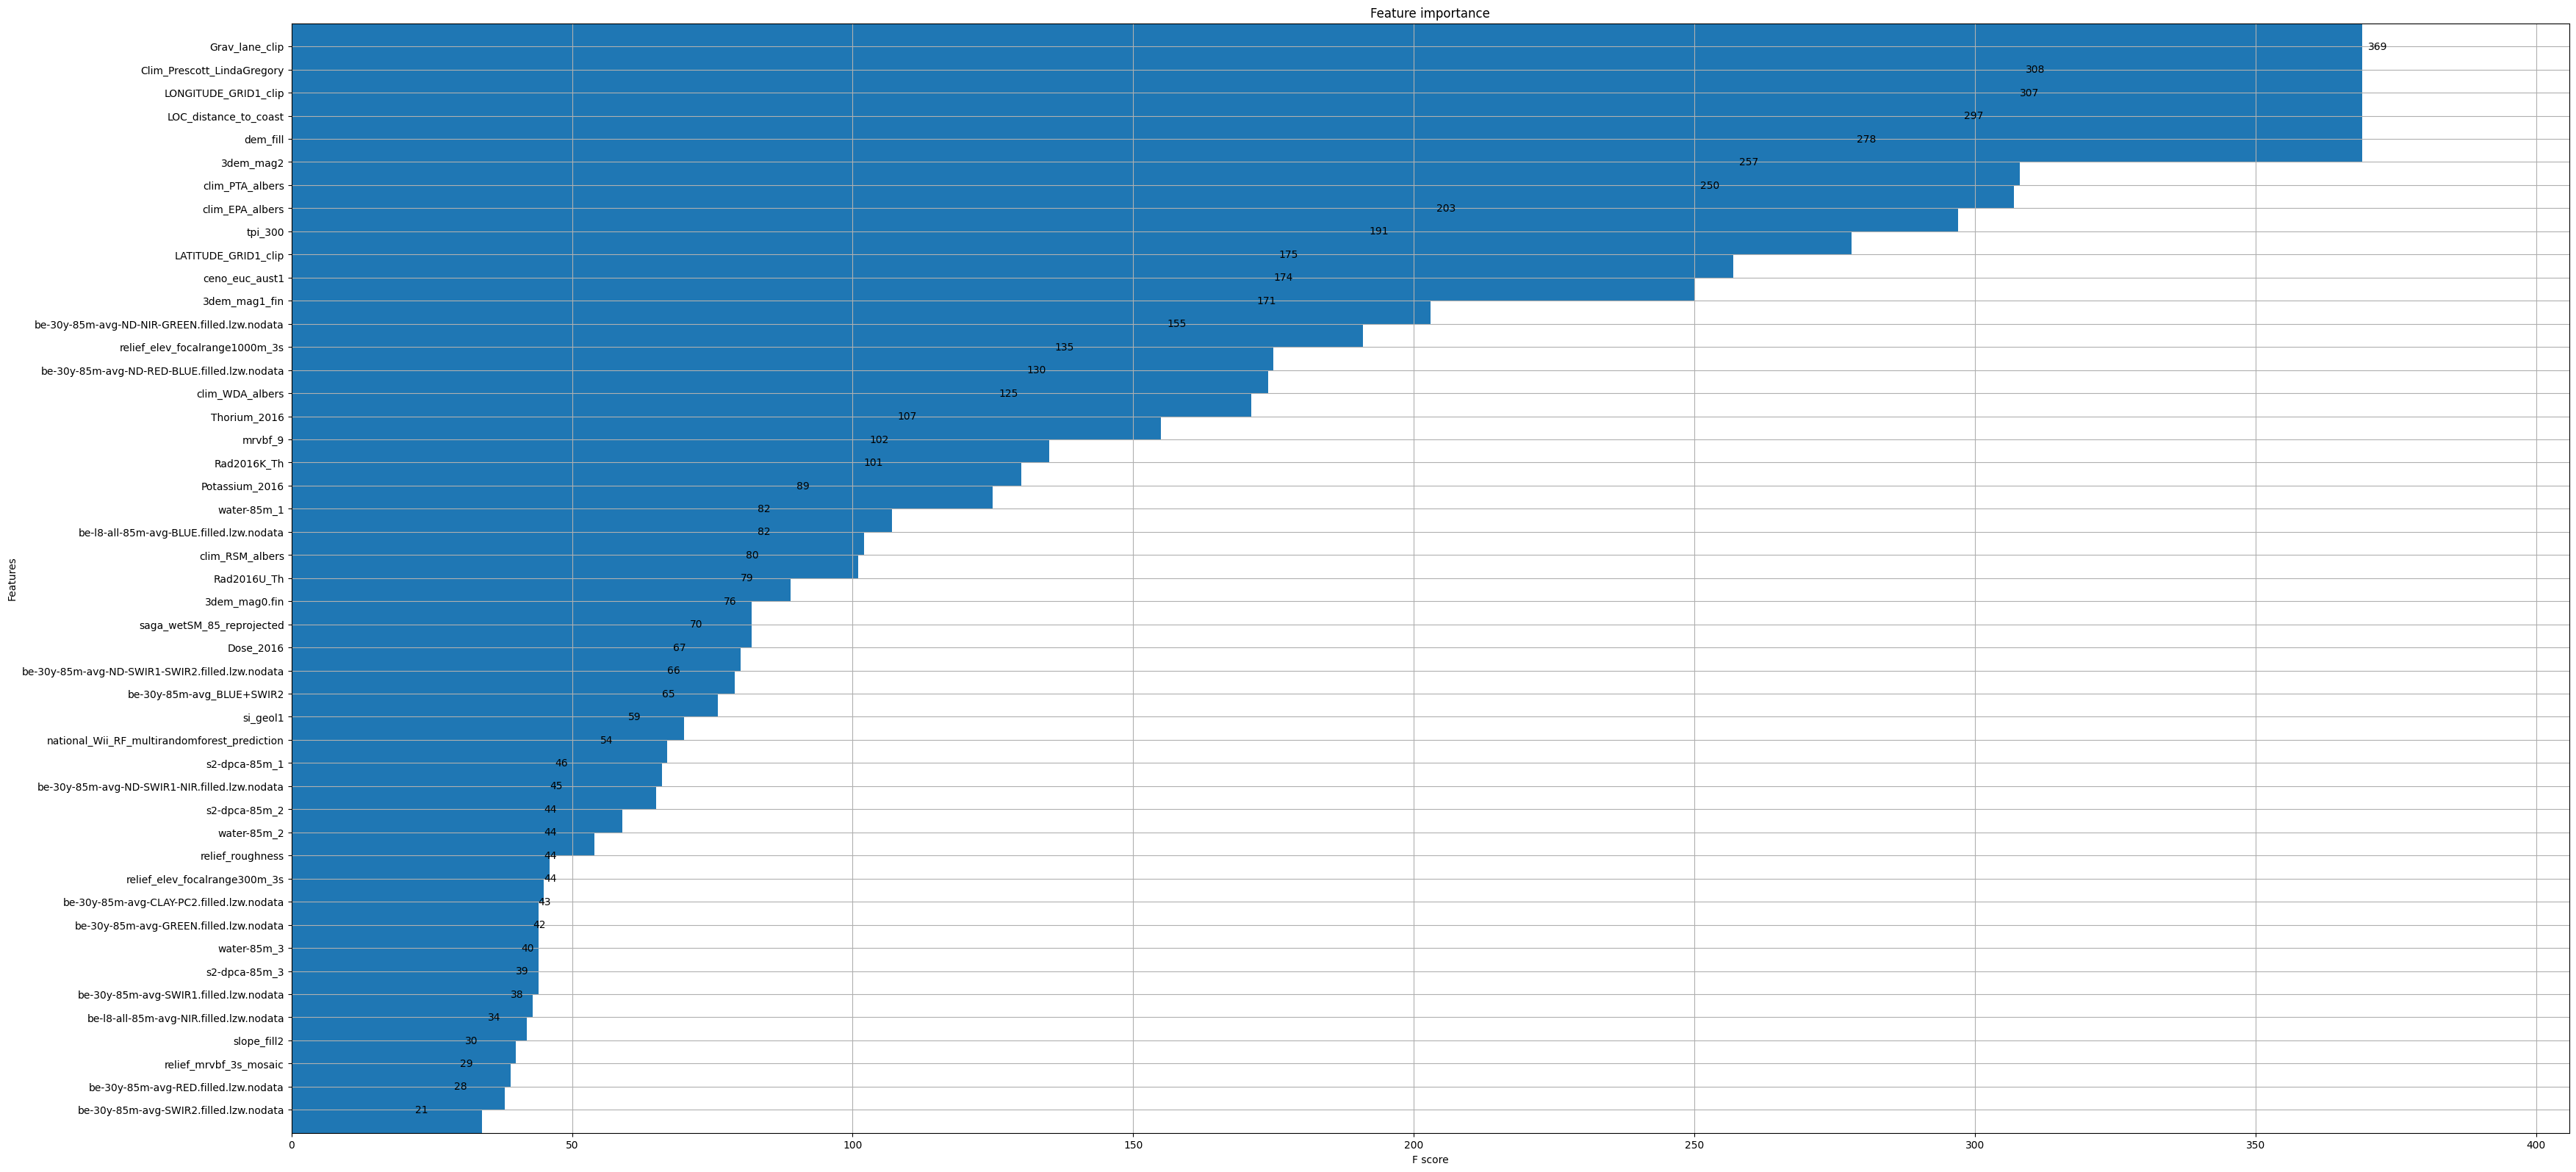

In [21]:
plt.rcParams['figure.figsize'] = [40, 20]
plt.rcParams['figure.dpi'] = 100
plot_importance(model,height=10)
pyplot.show()

In [13]:
model.fit

<bound method XGBModel.fit of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)>